# Pool Elo

In [38]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import csv

In [39]:
data = pd.read_csv('predatorCLP.csv')

In [40]:
players = pd.concat([data.WinnerName, data.LoserName] )

In [41]:
players.value_counts()

Albin Ouschan        52
Mieszko Fortunski    40
Niels Feijen         36
Billy Thorpe         33
Marc Bijsterbosch    27
Kelly Fisher         26
David Alcaide        22
Eklent Kaci          22
Naoyuki Oi           21
Chris Melling        15
Alex Kazakis         15
Roberto Gomez        14
Casper Matikainen    12
Ralf Souquet         12
Kristina Tkach       12
Denis Grabe           7
Jasmin Ouschan        6
Darren Appleton       6
Chris Robinson        6
dtype: int64

In [65]:
# How many players
nplayers = len(players.value_counts())
nplayers

19

<AxesSubplot:>

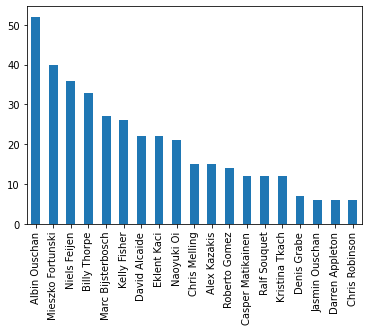

In [43]:
# Plot barplot
players.value_counts().plot(kind='bar')

<AxesSubplot:>

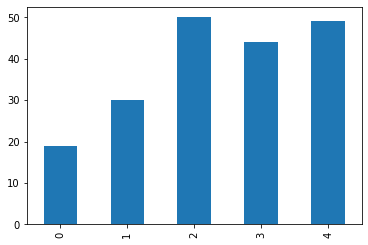

In [50]:
# Visualize Loser Racks
data.LoserRacks.value_counts().loc[range(0,5,1)].plot(kind='bar')

In [45]:
# Validate Even games per table 
data.Table.value_counts()

2    96
1    96
Name: Table, dtype: int64

In [46]:
# Validate Games per group 
data.Group.value_counts()

8    24
7    24
6    24
5    24
4    24
3    24
2    24
1    24
Name: Group, dtype: int64

In [47]:
# Validate 16 Semi Finals
data.isSemi.value_counts()

0    176
1     16
Name: isSemi, dtype: int64

In [48]:
# Validate 8 Finals
data.isFinal.value_counts()

0    184
1      8
Name: isFinal, dtype: int64

In [150]:
# Elo Rating System 
# Constants
INITIAL_RATING = 1500
ELO_WIDTH = 400
K = 50

In [151]:
def expected(A, B, elo_width): 
    proba = 1/ ( 1 + 10 ** ((B - A) / elo_width))
    return( proba )

# https://www.kaggle.com/kplauritzen/elo-ratings-in-python
def update_elo(winner_elo, loser_elo, k, elo_width):
    """
    https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
    """
    expected_win = expected(winner_elo, loser_elo, elo_width)
    change_in_elo = k * (1-expected_win)
    winner_elo += change_in_elo
    loser_elo -= change_in_elo
    return winner_elo, loser_elo

{'Albin Ouschan': 1500,
 'Mieszko Fortunski': 1500,
 'Niels Feijen': 1500,
 'Billy Thorpe': 1500,
 'Marc Bijsterbosch': 1500,
 'Kelly Fisher': 1500,
 'David Alcaide': 1500,
 'Eklent Kaci': 1500,
 'Naoyuki Oi': 1500,
 'Chris Melling': 1500,
 'Alex Kazakis': 1500,
 'Roberto Gomez': 1500,
 'Casper Matikainen': 1500,
 'Ralf Souquet': 1500,
 'Kristina Tkach': 1500,
 'Denis Grabe': 1500,
 'Jasmin Ouschan': 1500,
 'Darren Appleton': 1500,
 'Chris Robinson': 1500}

In [182]:

def run_tournament(data=data, INITIAL_RATING = INITIAL_RATING, ELO_WIDTH = ELO_WIDTH, K=K):
    
    # Initialize Elo Ratings
    elo_ratings = dict(zip(players.value_counts().index.unique(), 
                           np.repeat(INITIAL_RATING, nplayers)) )

    # Iterate through rows of dataframe 
    for index, row in data.iterrows():
        winner = row["WinnerName"]
        loser = row["LoserName"]
        if row['isSemi'] == True: 
            k = K*2
        elif row['isFinal'] == True: 
            k = K*3
        else: 
            k = K
        new_winner_rating, new_loser_rating = update_elo(elo_ratings[winner], elo_ratings[loser], k, ELO_WIDTH)
        elo_ratings[winner] = new_winner_rating
        elo_ratings[loser] = new_loser_rating
    ratings = pd.DataFrame.from_dict(elo_ratings, orient='index')
    ratings = ratings.rename(columns={0: "ratings"})
    return(ratings)

In [183]:
ratings = run_tournament()

In [184]:
ratings.sort_values(by='ratings', ascending = False)

,ratings
Albin Ouschan,1787.939127
Eklent Kaci,1679.107469
David Alcaide,1649.092329
Naoyuki Oi,1641.631940
Chris Melling,1631.589333
Niels Feijen,1578.185503
Marc Bijsterbosch,1572.369034
Denis Grabe,1504.205203
Alex Kazakis,1470.679688
Jasmin Ouschan,1439.981357


In [176]:
# Train-Test Split
winnersgroup = data[data.Group == 8]
prelims = data[data.Group != 8]

In [177]:
ratingsPrelims = run_tournament(data=prelims)

In [178]:
ratingsPrelims
ratingsPrelims.sort_values(by='ratings', ascending = False)


,ratings
David Alcaide,1705.970310
Niels Feijen,1689.670905
Eklent Kaci,1654.045591
Albin Ouschan,1648.862917
Chris Melling,1641.300990
Naoyuki Oi,1620.890778
Marc Bijsterbosch,1579.173243
Denis Grabe,1504.205203
Alex Kazakis,1470.679688
Jasmin Ouschan,1439.981357
